In [1]:
from API import *

In [31]:
def moyenne(kernel, X_, Y, repeat=100):
    mmd = np.zeros(repeat)
    for i in range(repeat):
        MMD = OMMD(kernel,np.random.choice(X_.flatten(), size = 100, replace=True).reshape((-1,1)))
        MMD.fit(np.random.choice(Y.flatten(), size = 100, replace=True).reshape((-1,1)))
        mmd[i] = MMD.MMD
        #print(f"Progression {(i/repeat)*100:.0f}%", end="\r", flush=True)
    return mmd.mean()

def est_partial_mean(kernel, X, y):
    return np.mean(kernel(y, X))


def estim_V(kernel, X, Y, repeat=10000):
    echantillions = np.zeros(repeat)
    for i in range(repeat):
        x1 = np.random.choice(X.flatten(), size = 1, replace=True).reshape((-1,1))
        x2 = np.random.choice(X.flatten(), size = 1, replace=True).reshape((-1,1))
        Y_1 = np.random.choice(Y.flatten(), size = 10, replace=True).reshape((-1,1))
        Y_2 = np.random.choice(Y.flatten(), size = 10, replace=True).reshape((-1,1))
        echantillions[i] = kernel(x1,x2) - est_partial_mean(kernel, x1, Y_1) - est_partial_mean(kernel, x2, Y_2)
    return echantillions.var()

def var_H(kernel, X, Y, alpha, size=100):
    return estim_V(kernel, X, Y) + 1/alpha*estim_V(kernel, Y, X)

def V1V0(sigma_H0, alpha, sigma_H1):
    """ Renvoie le premier terme de l'élément à optimiser"""
    return sigma_H0*inv_phi(1 - alpha)/sigma_H1
def MV(m, MMD_H1, sigma_H1):
    """ Renvoie le deuxième terme de l'élément à optimiser"""
    return np.sqrt(m/2)*MMD_H1/sigma_H1

In [32]:
def moyenne_MC(kernel, law_p, law_q, repeat=100):
    mmd = np.zeros(repeat)
    for i in range(repeat):
        MMD = OMMD(kernel, law_p(100))
        MMD.fit(law_q(100))
        mmd[i] = MMD.MMD
        #print(f"Progression {(i/repeat)*100:.0f}%", end="\r", flush=True)
    return mmd.mean()

def est_partial_mean_MC(kernel, y,law_p):
    return np.mean(kernel(y, law_p(10)))


def estim_V_MC(kernel, law_p, law_q, repeat=10000):
    echantillions = np.zeros(repeat)
    for i in range(repeat):
        x1 = law_p(1)
        x2 = law_p(1)
        echantillions[i] = kernel(x1,x2) - est_partial_mean_MC(kernel, x1, law_q) - est_partial_mean_MC(kernel, x2, law_q)
    return echantillions.var()

def var_H_MC(kernel, law_p, law_q, alpha, size=100):
    return estim_V_MC(kernel, law_p, law_q) + 1/alpha*estim_V_MC(kernel, law_q, law_p)

def V1V0(sigma_H0, alpha, sigma_H1):
    """ Renvoie le premier terme de l'élément à optimiser"""
    return sigma_H0*inv_phi(1 - alpha)/sigma_H1
def MV(m, MMD_H1, sigma_H1):
    """ Renvoie le deuxième terme de l'élément à optimiser"""
    return np.sqrt(m/2)*MMD_H1/sigma_H1

In [4]:
law_p = normal(0,1)
law_q = normal(2,1)
kernel  = gaussian(1)

In [21]:
%%time
L_bootstrap = []
for _ in range(100):
    X = law_p(10000)
    Y = law_q(10000)
    L_bootstrap.append(moyenne(kernel, X, Y))

CPU times: user 2min 44s, sys: 168 ms, total: 2min 44s
Wall time: 2min 44s


In [22]:
%%time
L_MC = []
for _ in range(100):
    L_MC.append(moyenne_MC(kernel, law_p, law_q))

CPU times: user 2min 43s, sys: 144 ms, total: 2min 43s
Wall time: 2min 43s


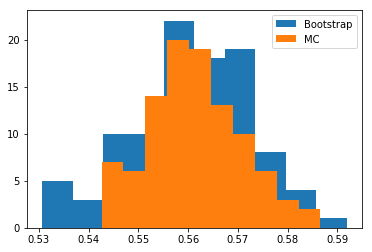

In [28]:
plt.hist(L_bootstrap, label='Bootstrap');
plt.hist(L_MC, label='MC');
plt.legend();

In [29]:
print(f"moyenne bootsrap : {np.mean(L_bootstrap)}")
print(f"moyenne MC : {np.mean(L_MC)}")
print(f"variance bootsrap : {np.var(L_bootstrap)}")
print(f"variance MC : {np.var(L_MC)}")

moyenne bootsrap : 0.5609725610177236
moyenne MC : 0.5615002589538775
variance bootsrap : 0.0001446393950433846
variance MC : 8.924175018522107e-05


In [24]:
##### 

In [30]:
var_H(kernel, X, Y, alpha=0.1, size=100)

2.2662620335446113

In [37]:
var_H_MC(kernel, law_p, law_q, alpha=0.1, size=100)

2.470042984296022

In [38]:
%%time
L_bootstrap = []
for _ in range(100):
    X = law_p(10000)
    Y = law_q(10000)
    L_bootstrap.append(var_H(kernel, X, Y, alpha=0.1, size=100))

CPU times: user 2min 19s, sys: 1.05 s, total: 2min 20s
Wall time: 2min 20s


In [18]:
%%time
L_MC = []
for _ in range(100):
    L_MC.append(var_H_MC(kernel, law_p, law_q, alpha=0.1, size=100))

CPU times: user 14min 39s, sys: 3.46 s, total: 14min 42s
Wall time: 14min 40s


In [9]:
#plt.hist(L_bootstrap, label='Bootstrap');
plt.hist(L_MC, label='MC');
plt.legend();

NameError: name 'L_bootstrap' is not defined

In [19]:
#print(f"moyenne bootsrap : {np.mean(L_bootstrap)}")
print(f"moyenne MC : {np.mean(L_MC)}")
#print(f"variance bootsrap : {np.var(L_bootstrap)}")
print(f"variance MC : {np.var(L_MC)}")

moyenne MC : 2.5170986021626502
variance MC : 0.00048676635353008565


--> Première conclusion, moins de variance en échantillonnant qu'en rééchantillonnant

In [33]:
%%time
L_sigma_H0_Boot = []
L_sigma_H1_Boot = []
L_V1V0_Boot = []
for _ in range(100):
    X = law_p(10000)
    Y = law_q(10000)
    sigma_H0 = var_H(kernel, X, X, alpha=0.1, size=100)
    sigma_H1 = var_H(kernel, X, Y, alpha=0.1, size=100)
    v1v0 = V1V0(sigma_H0, 0.05, sigma_H1)
    L_sigma_H0_Boot.append(sigma_H0)
    L_sigma_H1_Boot.append(sigma_H1)
    L_V1V0_Boot.append(v1v0)

CPU times: user 44min 42s, sys: 6.46 s, total: 44min 48s
Wall time: 45min 1s


In [ ]:
%%time
L_sigma_H0_MC = []
L_sigma_H1_MC = []
L_V1V0_MC = []
for _ in range(100):
    sigma_H0 = var_H_MC(kernel, law_p, law_p, alpha=0.1, size=100)
    sigma_H1 = var_H_MC(kernel, law_p, law_q, alpha=0.1, size=100)
    v1v0 = V1V0(sigma_H0, 0.05, sigma_H1)
    L_sigma_H0_MC.append(sigma_H0)
    L_sigma_H1_MC.append(sigma_H1)
    L_V1V0_MC.append(v1v0)

In [ ]:
plt.hist(L_sigma_H0_Boot, label='Bootstrap');
plt.hist(L_sigma_H0_MC, label='MC');
plt.legend();
print(f"moyenne bootsrap : {np.mean(L_sigma_H0_Boot)}")
print(f"moyenne MC : {np.mean(L_sigma_H0_MC)}")
print(f"variance bootsrap : {np.var(L_sigma_H0_Boot)}")
print(f"variance MC : {np.var(L_sigma_H0_MC)}")

In [ ]:
plt.hist(L_sigma_H1_Boot, label='Bootstrap');
plt.hist(L_sigma_H1_MC, label='MC');
plt.legend();
print(f"moyenne bootsrap : {np.mean(L_sigma_H1_Boot)}")
print(f"moyenne MC : {np.mean(L_sigma_H1_MC)}")
print(f"variance bootsrap : {np.var(L_sigma_H1_Boot)}")
print(f"variance MC : {np.var(L_sigma_H1_MC)}")

In [ ]:
plt.hist(L_V1V0_Boot, label='Bootstrap');
plt.hist(L_V1V0_MC, label='MC');
plt.legend();
print(f"moyenne bootsrap : {np.mean(L_V1V0_Boot)}")
print(f"moyenne MC : {np.mean(L_V1V0_MC)}")
print(f"variance bootsrap : {np.var(L_V1V0_Boot)}")
print(f"variance MC : {np.var(L_V1V0_MC)}")